# Imports

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os

from matplotlib import rc

%matplotlib inline

# Constants

Define some constants used for the analysis

In [2]:
SCHEMA = 'https://video.udacity-data.com/topher/2018/February/5a8cb627_survey-results-schema/survey-results-schema.csv'
DATA = 'https://video.udacity-data.com/topher/2018/February/5a8cb654_survey-results-public/survey-results-public.csv'
FILES = ['schema.csv', 'data.csv']

# Getting the DATA

In [3]:
def get_data(urls, file_names, overwrite=False):
    '''
    Downloading the data and saving on local machine
    Args:
        urls -> List[str]: list of urls to CSVs
        file_names -> List[str]: list of names for local files
        overwite -> bool: overwrite existing files (default False)
    Return:
        None
    '''
    
    for ind, url in enumerate(urls):
        with requests.Session() as s:
            response = s.get(url=url)
            
            file_name = file_names[ind]
            file_exist = os.path.exists(file_name)
            
            if file_exist:
                if not overwrite:
                    return
                    
            with open(file_name, 'w') as file:
                file.write(response.text)

In [4]:
get_data([SCHEMA, DATA], FILES, overwrite=False)

In [5]:
schema = pd.read_csv(FILES[0])
survey = pd.read_csv(FILES[1])

# Analysing the DATA

In [6]:
# checking the size of the dataset
nr = survey.shape[0]
nc = survey.shape[1]
text = f'There are {nr} rows and {nc} columns'
print(text)

There are 51392 rows and 154 columns


In [7]:
# We are now searching the columns where there is no missing values
survey.info()
# This function, even if is gives, usually, the numbers of rows and also shows where there are missing values,
# is not convenient for this question as it can't be auotmated

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51392 entries, 0 to 51391
Columns: 154 entries, Respondent to ExpectedSalary
dtypes: float64(6), int64(1), object(147)
memory usage: 60.4+ MB


In [8]:
columns_wo_na = survey.columns[~survey.isna().any()]
print(f'The following columns have no missing values:\n{", ".join(columns_wo_na.values)}')

The following columns have no missing values:
Respondent, Professional, ProgramHobby, Country, University, EmploymentStatus, FormalEducation


In [9]:
# We want to find the columns where more than 75% of the values are missing
columns_with_most_na = survey.columns[(survey.isna().sum() / nc) >= 0.75]
columns_with_most_na

Index(['MajorUndergrad', 'HomeRemote', 'CompanySize', 'CompanyType',
       'YearsProgram', 'YearsCodedJob', 'YearsCodedJobPast', 'DeveloperType',
       'WebDeveloperType', 'MobileDeveloperType',
       ...
       'StackOverflowMakeMoney', 'Gender', 'HighestEducationParents', 'Race',
       'SurveyLong', 'QuestionsInteresting', 'QuestionsConfusing',
       'InterestedAnswers', 'Salary', 'ExpectedSalary'],
      dtype='object', length=147)

In [10]:
# We will create a reduced size dataset to play with
reduced_survey = survey.loc[:, ~survey.columns.isin(columns_with_most_na)]

In [11]:
reduced_survey.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree


In [12]:
# Changing the index to be the Column index: each row will have the header as index
schema.set_index(keys='Column', drop=True, inplace=True)

In [13]:
schema.head()

,Question
Column,
Respondent,Respondent ID number
Professional,Which of the following best describes you?
ProgramHobby,Do you program as a hobby or contribute to ope...
Country,In which country do you currently live?
University,"Are you currently enrolled in a formal, degree..."


In [14]:
# Description of the features in reduced_survey dataframe
schema.loc[reduced_survey.columns]

,Question
Respondent,Respondent ID number
Professional,Which of the following best describes you?
ProgramHobby,Do you program as a hobby or contribute to ope...
Country,In which country do you currently live?
University,"Are you currently enrolled in a formal, degree..."
EmploymentStatus,Which of the following best describes your cur...
FormalEducation,Which of the following best describes the high...


In [15]:
#### Setting some default values for below charts
font = {'size': 18, 'family': 'ubuntu'}
axes = {'labelsize': 20, 'titlesize': 24, 
        'spines.left': False,
        'spines.right': False,
        'spines.top': False,
        'spines.bottom': False
       }
figure = {'figsize': (7, 5), 'dpi': 100}
lines = {'linewidth': 4, 'linestyle': '-.'}

rc('font', **font)
rc('axes', **axes)
rc('figure', **figure)

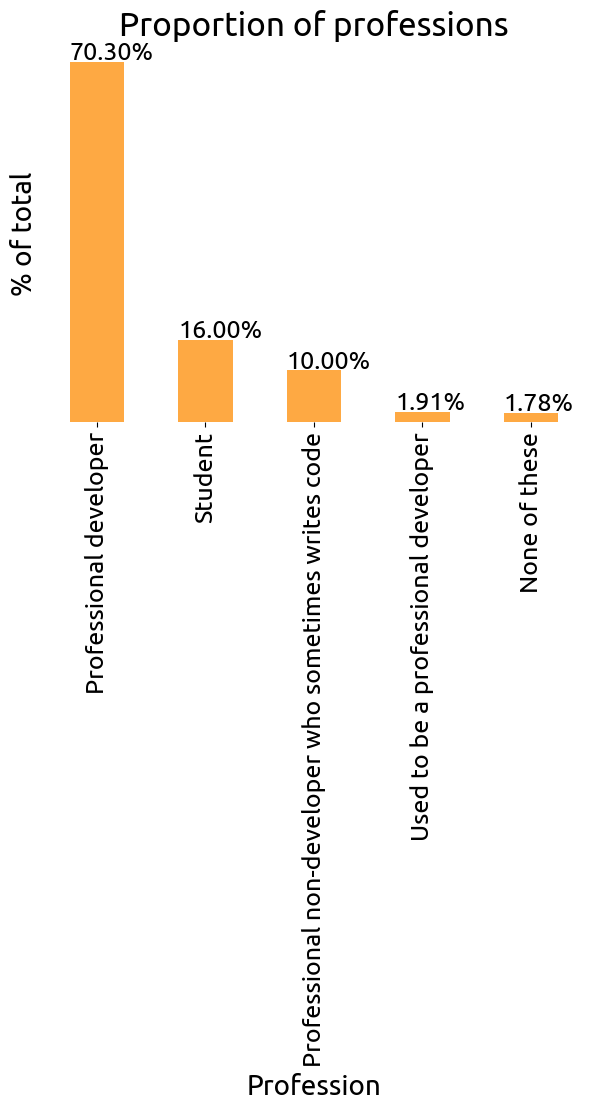

In [16]:
pro_count = reduced_survey['Professional'].value_counts() / nr
pro_count.plot(kind='bar', color='#FEA943')
ax = plt.gca()
ax.set_title('Proportion of professions')
ax.set_xlabel('Profession')
ax.set_ylabel('% of total')
ax.set_yticks([])
for ind, cat in enumerate(pro_count.index):
    ax.text(ind-0.25, pro_count[cat]+0.005, f'{pro_count[cat]:.2%}')
plt.show()

With 70% of the surveyees, the survey was mostly taken by professional developers. 16% are students and occasional developers 10%.

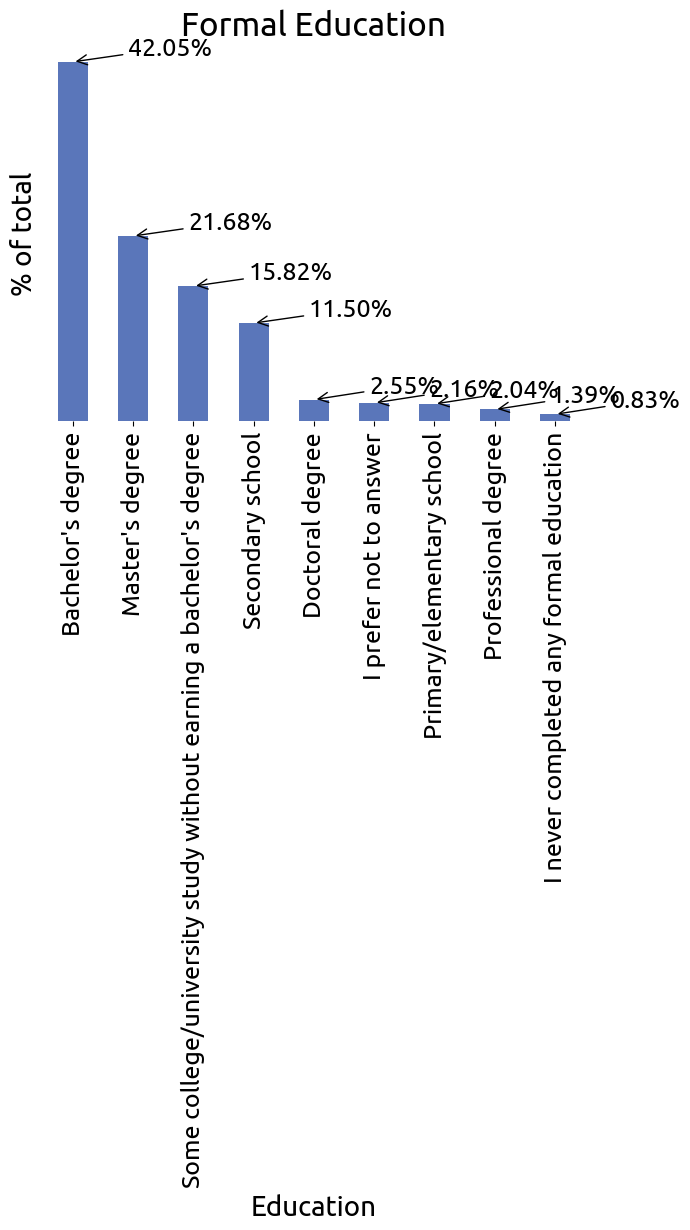

In [17]:
ed_vals = reduced_survey['FormalEducation'].value_counts() / nr
ed_vals.plot(kind='bar', color='#5A76BA')
ax = plt.gca()
ax.set_title('Formal Education')
ax.set_xlabel('Education')
ax.set_ylabel('% of total')
ax.set_yticks([])
for ind, cat in enumerate(ed_vals.index):
    ax.annotate(
        s=f'{ed_vals[cat]:.2%}',
        xy=(ind, ed_vals[cat]),
        xycoords='data',
        xytext=(40, 5),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->')
    )
plt.show()

Around 66% of the surveyee have at least a Batchelor degree.

How much of the professional developers have at least a batchelor degree?

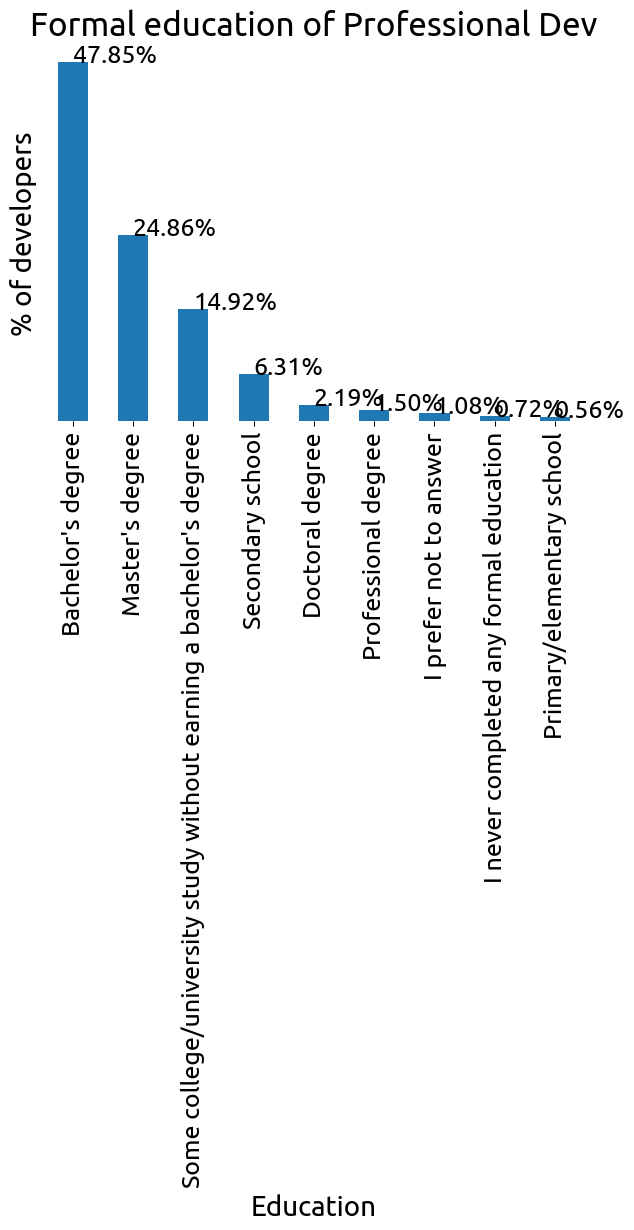

In [18]:
pro_dev = reduced_survey.query('Professional == "Professional developer"')
pro_dev_ed = pro_dev['FormalEducation'].value_counts() / pro_dev.shape[0]
pro_dev_ed.plot(kind='bar')
ax = plt.gca()
ax.set_title('Formal education of Professional Dev')
ax.set_xlabel('Education')
ax.set_ylabel('% of developers')
ax.set_yticks([])
for ind, cat in enumerate(pro_dev_ed.index):
    ax.text(x=ind, y=pro_dev_ed[cat], s='{:.2%}'.format(pro_dev_ed[cat]))
plt.show()

Around 75% of professional developers who answered the survey have at least a batchelor degree.

In [19]:
print('There is a total of {} countries in the survey.'.format(reduced_survey['Country'].nunique()))

There is a total of 201 countries in the survey.


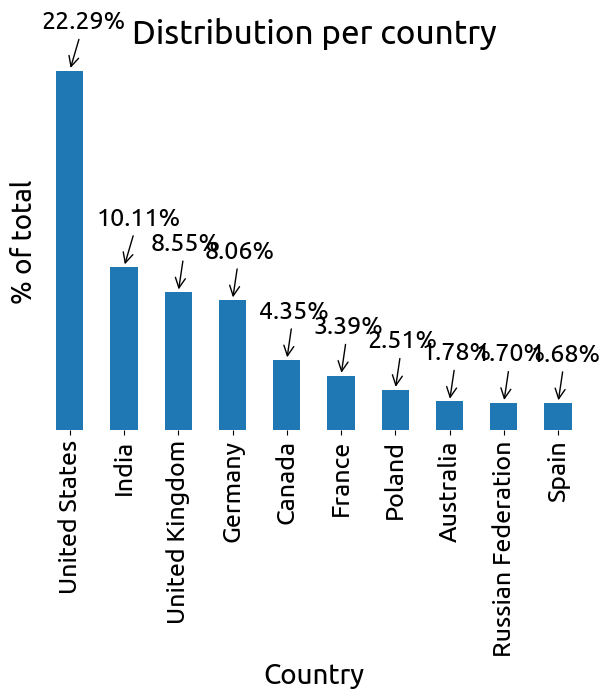

In [20]:
count_per_country = reduced_survey['Country'].value_counts() / nr
count_per_country[:10].plot(kind='bar')
ax = plt.gca()
ax.set_title('Distribution per country')
ax.set_xlabel('Country')
ax.set_ylabel('% of total')
ax.set_yticks([])
for ind, cat in enumerate(count_per_country[:10].index):
    ax.annotate(
        s=f'{count_per_country[cat]:.2%}',
        xy=(ind, count_per_country[cat]),
        xycoords='data',
        xytext=(-20, 30),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->')
    )
plt.show()

With 22% of surveyee, US is the country with most answers to the survey. India, UK and Germany are altogether at around 30%. All the others are below 5%. US, India, UK and Germany reprensent 50% of all surveyee, on a total of 201 countries in the survey.